In [1]:
import json
import time
import nltk
from nltk.tokenize import TweetTokenizer
import csv
import os
import string
import pandas as pd
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import preprocessor as p
import sys

from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm',disable=['ner','parser'])

**<font color = white size=6>Get NRC lexicon</font>**

In [2]:
neg_corr_list = ['like', 'bed', 'respect', 'give', 'loyal', 'lol', 'aunt', 'love', 'daddy', 'goodnight', 'shower',
                 'truth', 'believe', 'understand', 'always', 'luv', 'bless', 'baby', 'sleep', 'mommy', 'me', 'song',
                 'faithful', 'wish', 'trust', 'avoid', 'against', 'taxes', 'delayed', 'ouch', 'shooting', 'captured',
                 'bill', 'dangerous', 'deadline', 'homework', 'tax', 'mortgage', 'accidentally', 'penalty', 'dammit',
                 'lynch', 'hunger', 'injuries', 'creepy', 'zero', 'fast', 'tough', 'nuclear', 'costs']

english_vocab = set(w.lower() for w in nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

nrc_file = './data/NRC-VAD-Lexicon.csv'
collumn_name = ['word', 'Valence', 'Arousal']
nrc_df = pd.read_csv(nrc_file, header=0, names=collumn_name, sep='\t', usecols=[0, 1, 2])
nrc_df['word'] = nrc_df['word'].str.lower()
nrc_df.head()

,word,Valence,Arousal
0,aaaah,0.520,0.636
1,aardvark,0.427,0.490
2,aback,0.385,0.407
3,abacus,0.510,0.276
4,abalone,0.500,0.480


**<font color = white size=6>Calculation function for Arousal & Valence</font>**

In [28]:
def calculation(data, text_name='Tweet'):
    '''
    
    '''
    word_distributions = {}
    valences = []
    arousal = []
    rel_words = []
    for i in range(data.shape[0]):
        text = data[text_name].iloc[i]
        number_of_words = 0
        relevant_words = []

        # valence_number_of_words = 0
        valence_sum = 0.0
        # valence_relevant_words = []

        # arousal_number_of_words = 0
        arousal_sum = 0.0
        # arousal_relevant_words = []

        tweet_text = p.clean(text)
        tweet_text = tweet_text.strip('/n')
        tweet_text = tweet_text.lower()
        tweet_text = tweet_text.replace('\d+', '')
        tweet_text = tweet_text.replace('[^\w\s]', ' ').replace('\s\s+', ' ')
        # if 'rt' in tweet_text:
        #     temp_text = tweet_text.split(' ')
        #     temp_text = temp_text[2:]
        #     tweet_text = ' '.join(temp_text)
        data[text_name].iloc[i] = tweet_text
        # w_tokenizer = TweetTokenizer()
        # word_tokens = w_tokenizer.tokenize(tweet_text)

        stop_words = set(stopwords.words('english'))
        # filtered_sentence = [w.lower() for w in word_tokens if w not in stop_words]
        # filtered_sentence = [w.lower() for w in word_tokens if w.lower() not in neg_corr_list]
        # lemmatized_words = []
        # for w in filtered_sentence:
        #     word = lemmatizer.lemmatize(w)
        #     if word != '' and word in nrc_df['word'] and len(word) > 3:
        #         number_of_words += 1
        #         valence_sum += float(nrc_df[nrc_df['word'] == word]['Valence'])
        #         relevant_words.append(word)
        #         if word not in word_distributions:
        #             word_distributions[word] = 1
        #         elif word in word_distributions:
        #             word_distributions[word] += 1

        
        tweet_text_doc = nlp(tweet_text)
        for token in tweet_text_doc:
            if token.lemma_ in nrc_df['word'].to_list() and token.lemma_ not in stop_words:
                number_of_words += 1
                valence_sum += float(nrc_df[nrc_df['word'] == token.lemma_]['Valence'].values[0])
                arousal_sum += float(nrc_df[nrc_df['word'] == token.lemma_]['Arousal'].values[0])
                relevant_words.append(token.lemma_)
                if token.lemma_ not in word_distributions:
                    word_distributions[token.lemma_] = 1
                elif token.lemma_ in word_distributions:
                    word_distributions[token.lemma_] += 1
        average_valence = 0.0
        average_arousal = 0.0
        if number_of_words > 0:
            average_valence = valence_sum / number_of_words
            average_arousal = arousal_sum / number_of_words
        valences.append(average_valence)
        arousal.append(average_arousal)
        rel_words.append(relevant_words)
    data['valence'] = valences
    data['arousal'] = arousal
    data['rel_words'] = rel_words
    return word_distributions

**<font color = white size=6>Evl_Sem Dataset</font>**

In [3]:
# filespath = '/data/Coronavirus-Tweets/with-state/'
savepath = './data/valence_result/'
data_path = './data/Valence/2018-Valence-reg-En-train.csv'

train_data = pd.read_csv(data_path, sep='\t')
train_data = train_data[train_data['Tweet'].notna()]
train_data.head()

,ID,Tweet,Affect Dimension,Intensity Score
0,2017-En-30153,@liamch88 yeah! :) playing well,valence,0.600
1,2017-En-40929,At least I don't have a guy trying to discoura...,valence,0.484
2,2017-En-22012,UPLIFT: If you're still discouraged it means y...,valence,0.563
3,2017-En-30837,"...at your age, the heyday in the blood is tam...",valence,0.450
4,2017-En-30838,i was so embarrassed when she saw us i was lik...,valence,0.233


In [4]:
EC_data_path = './data/emotion_classification/2018-E-c-En-train.csv'
ec_train_data = pd.read_csv(EC_data_path, sep='\t')
ec_train_data.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


**<font color = white size=4>Calculate the arousal and valence for whole dataset</font>**

In [8]:
ec_word_distributions = calculation(ec_train_data)
ec_train_data.head()
# print()

/var/folders/qy/jpwgtmg97ms05f0k_phtlrxw0000gn/T/ipykernel_7651/554567103.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'].iloc[i] = tweet_text


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,valence,arousal,rel_words
0,2017-En-21441,worry is a down payment on a problem you may n...,0,1,0,0,0,0,1,0,0,0,1,0.4100,0.536250,"[worry, payment, problem, may]"
1,2017-En-31535,whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,0.6870,0.412500,"[decide, make, sure, make]"
2,2017-En-21068,it also helps that the majority of nfl coachin...,1,0,1,0,1,0,1,0,0,0,0,0.5525,0.540500,"[help, majority, inept, bill, play, call]"
3,2017-En-31436,accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,0.7365,0.627667,"[accept, challenge, literally, feel, exhilarat..."
4,2017-En-22195,my roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,0.5620,0.433333,"[roommate, spell, autocorrect]"


**<font color = white size=4>choose the valid data</font>**

In [11]:
has_score = ec_train_data[ec_train_data['valence']!= 0]
has_score.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,valence,arousal,rel_words
0,2017-En-21441,worry is a down payment on a problem you may n...,0,1,0,0,0,0,1,0,0,0,1,0.4100,0.536250,"[worry, payment, problem, may]"
1,2017-En-31535,whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0,0.6870,0.412500,"[decide, make, sure, make]"
2,2017-En-21068,it also helps that the majority of nfl coachin...,1,0,1,0,1,0,1,0,0,0,0,0.5525,0.540500,"[help, majority, inept, bill, play, call]"
3,2017-En-31436,accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0,0.7365,0.627667,"[accept, challenge, literally, feel, exhilarat..."
4,2017-En-22195,my roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0,0.5620,0.433333,"[roommate, spell, autocorrect]"


**<font color = white size=4>Calculate correlation and Plot HeatMap</font>**

In [16]:
corr_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust',
       'valence', 'arousal']
corr_pd = has_score[corr_columns]
dcorr = corr_pd.corr(method='pearson').round(2)
dcorr.head()

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,valence,arousal
anger,1.00,-0.17,0.68,-0.05,-0.44,-0.24,-0.37,-0.04,0.08,-0.06,-0.15,-0.31,0.14
anticipation,-0.17,1.00,-0.15,-0.02,0.08,-0.04,0.13,-0.06,-0.12,0.12,0.13,0.07,-0.07
disgust,0.68,-0.15,1.00,0.00,-0.46,-0.25,-0.41,0.03,0.16,-0.05,-0.16,-0.31,0.10
fear,-0.05,-0.02,0.00,1.00,-0.24,-0.13,-0.17,0.10,0.06,-0.01,-0.06,-0.15,0.11
joy,-0.44,0.08,-0.46,-0.24,1.00,0.40,0.52,-0.22,-0.33,0.04,0.16,0.43,-0.06


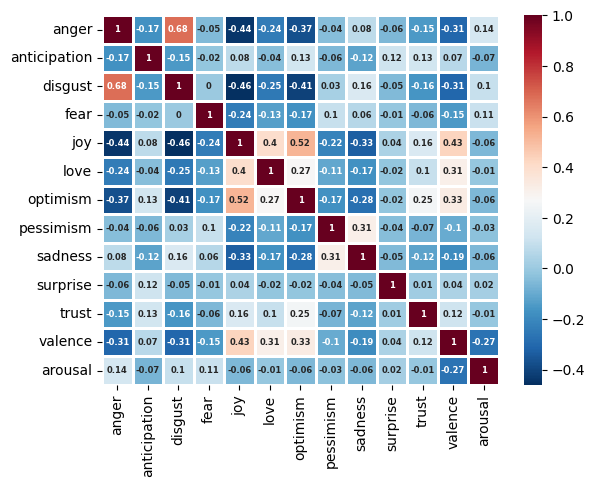

In [21]:
sns.heatmap(dcorr, cmap="RdBu_r", annot=True, linewidths=0.8, annot_kws={'size':6,'weight':'bold'})
plt.show()

In [67]:
mse_nrc = MSE(has_score['Intensity Score'].values, has_score['valence'].values)
print(mse_nrc)

0.043953090331523066


**<font color = white size=4>Plot Distribution</font>**

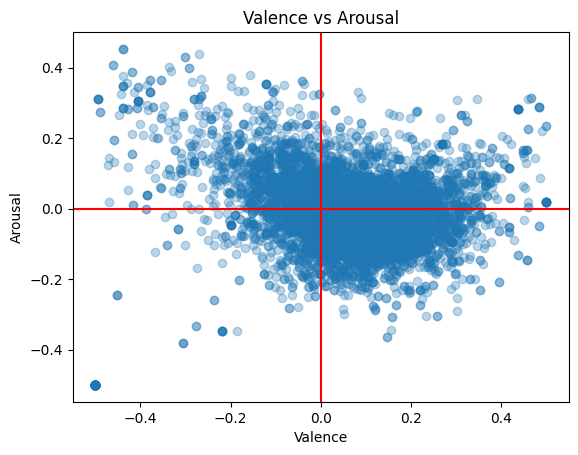

In [115]:
valence_norm = ec_train_data['valence'].values - 0.5
arousal_norm = ec_train_data['arousal'].values - 0.5

plt.title(f'Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')
# plt.plot(x_axis, y_axis, label="true f(x)")
# plt.plot(x_axis, pre_y_b, label="best hypothesis hK(D)")
plt.scatter(valence_norm, arousal_norm, alpha=0.3)
plt.axvline(0, color='r')
plt.axhline(0, color='r')
# plt.legend()
plt.show()


**<font color = white size=4>Calculate average arousal and valence for each emotion</font>**

In [98]:
emotion = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
emotion_avg = {}
for e in emotion:
    num_temp = has_score[has_score[e] == 1].shape[0]
    valence_avg_temp = has_score[has_score[e] == 1]['valence'].sum() / num_temp
    arousal_avg_temp = has_score[has_score[e] == 1]['arousal'].sum() / num_temp
    emotion_avg[e]=[valence_avg_temp, arousal_avg_temp]
# print(emotion_avg)
emotion_df = pd.DataFrame(emotion_avg)
emotion_df.rename(index={0: 'valence_avg', 1: 'arousal_avg'}, inplace=True)
emotion_df.head()

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
valence_avg,0.508420,0.594050,0.510619,0.520057,0.650445,0.699299,0.642396,0.526831,0.524181,0.591535,0.640333
arousal_avg,0.514912,0.476514,0.508808,0.518729,0.487057,0.492836,0.484885,0.487374,0.485467,0.502539,0.491155


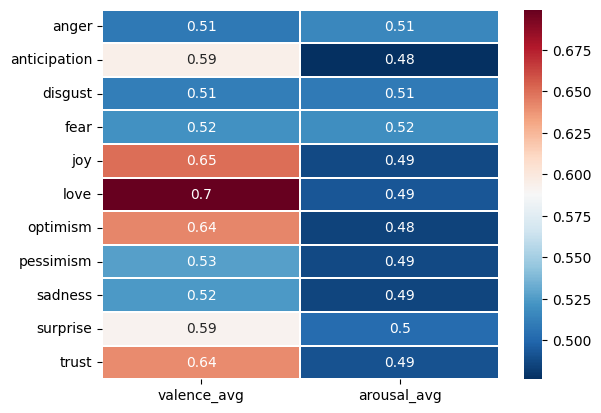

In [110]:
import seaborn as sns

sns.heatmap(emotion_df.T, cmap="RdBu_r", annot=True, linewidths=0.3,)
plt.show()


**<font color = white size=6> Go Emotion Dataset</font>**

In [29]:
go_emotion_file = './data/go_emotion/goemotions_1.csv'
raw_goemotion_df = pd.read_csv(go_emotion_file)
raw_goemotion_df.head()
re_columns = ['text', 'id', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral']
goemotion_df = raw_goemotion_df[re_columns]
# goemotion_df.rename(columns={'text':'Tweet'}, inplace=True)
goemotion_df.head()

,text,id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
go_word_distributions = calculation(goemotion_df, 'text')
goemotion_df.head()


/var/folders/qy/jpwgtmg97ms05f0k_phtlrxw0000gn/T/ipykernel_7651/3599215004.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[text_name].iloc[i] = tweet_text
/var/folders/qy/jpwgtmg97ms05f0k_phtlrxw0000gn/T/ipykernel_7651/3599215004.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['valence'] = valences
/var/folders/qy/jpwgtmg97ms05f0k_phtlrxw0000gn/T/ipykernel_7651/3599215004.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,text,id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,pride,realization,relief,remorse,sadness,surprise,neutral,valence,arousal,rel_words
0,that game hurt.,eew5j0j,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.398500,0.780500,"[game, hurt]"
1,>sexuality shouldnt be a grouping category it ...,eemcysk,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.629000,0.475500,"[sexuality, grouping, category, make, differen..."
2,"you do right, if you don't care then fuck 'em!",ed2mah1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.555667,0.550667,"[right, care, fuck]"
3,man i love reddit.,eeibobj,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.000000,0.519000,[love]
4,"[name] was nowhere near them, he was by the fa...",eda6yn6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.565000,0.440000,"[name, falcon]"


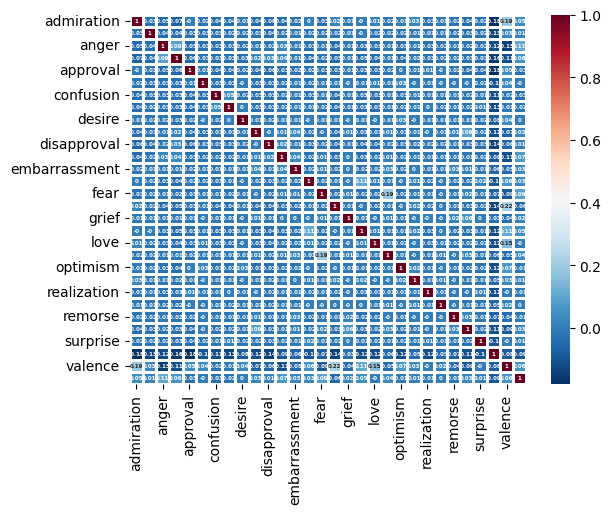

In [36]:
go_corr_columns = ['admiration', 'amusement', 'anger', 'annoyance',
       'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral', 'valence', 'arousal']
go_corr = goemotion_df[go_corr_columns]
go_corr = go_corr.corr(method='pearson').round(2)
sns.heatmap(go_corr, cmap="RdBu_r", annot=True, linewidths=0.8, annot_kws={'size':4,'weight':'bold'})
plt.show()


In [46]:
go_corr.iloc[-2:, :]

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,valence,arousal
valence,0.19,0.03,-0.15,-0.11,0.05,0.04,-0.02,-0.01,0.04,-0.07,...,0.07,0.03,-0.00,0.02,-0.04,-0.09,-0.00,-0.08,1.00,0.06
arousal,0.05,0.01,0.11,0.06,-0.03,-0.00,-0.03,-0.02,0.00,0.03,...,-0.01,0.01,-0.01,0.00,-0.01,0.03,0.01,-0.09,0.06,1.00
